<a href="https://colab.research.google.com/github/Talha-Naeem/DeepLearning-Works/blob/master/Ch_6_from_6_28_to_6_49.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#6.28 Inspecting the data of the Jena weather dataset

In [17]:
import os
import zipfile
!unzip -q  "/content/jena_climate_2009_2016.csv.zip"

In [ ]:
import os
data_dir = 'jena_climate'
fname = os.path.join(data_dir, '/content/jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
#6.29 Parsing the data

In [ ]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

In [ ]:
#6.30 Plotting the temperature timeseries

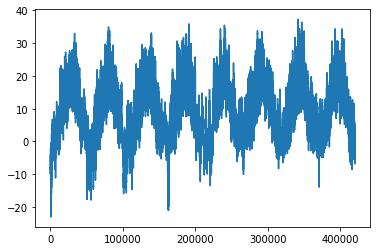

In [ ]:
from matplotlib import pyplot as plt
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

In [ ]:
#6.31 Plotting the first 10 days of the temperature timeseries

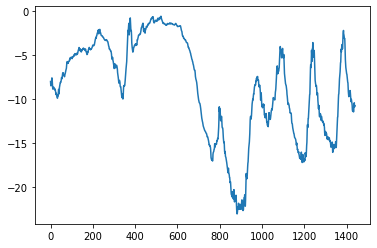

In [ ]:
plt.plot(range(1440), temp[:1440])

In [ ]:
# 6.32 Normalizing the data

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
#6.33 Generator yielding timeseries samples and their targets

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if  i + batch_size >= max_index:
                  i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
#6.34 Preparing the training, validation, and test generators

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size


In [ ]:
#6.35 Computing the common-sense baseline MAE

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2897359729905486


In [ ]:
#6.36 Converting the MAE back to a Celsius error

In [ ]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [ ]:
#6.37 Training and evaluating a densely connected model

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 1.7682 - val_loss: 1.0627
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.6211 - val_loss: 0.4398
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3531 - val_loss: 0.3558
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2874 - val_loss: 0.3124
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2641 - val_loss: 0.3220
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2518 - val_loss: 0.3074
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2428 - val_loss: 0.3214
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2346 - val_loss: 0.3102
Epoch 9/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2292 - val_loss: 0.3135
Epoch 

In [ ]:
#6.38 Plotting results

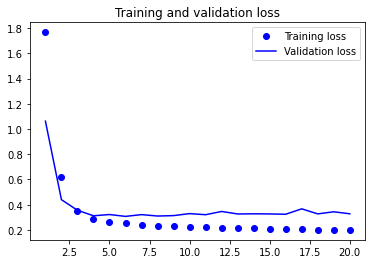

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#6.39 Training and evaluating a GRU-based model

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 73s 147ms/step - loss: 0.2975 - val_loss: 0.2680
Epoch 2/20
500/500 [==============================] - 71s 142ms/step - loss: 0.2840 - val_loss: 0.2658
Epoch 3/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2781 - val_loss: 0.2631
Epoch 4/20
500/500 [==============================] - 71s 142ms/step - loss: 0.2723 - val_loss: 0.2630
Epoch 5/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2674 - val_loss: 0.2658
Epoch 6/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2626 - val_loss: 0.2639
Epoch 7/20
500/500 [==============================] - 70s 140ms/step - loss: 0.2573 - val_loss: 0.2656
Epoch 8/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2531 - val_loss: 0.2626
Epoch 9/20
500/500 [==============================] - 71s 141ms/step - loss: 0.2475 - val_loss: 0.2622
Epoch 10/20
500/500 [==============================] - 75s 150ms/step - l

In [ ]:
#6.40 Training and evaluating a dropout-regularized GRU-based model

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 124s 248ms/step - loss: 0.3210 - val_loss: 0.2813
Epoch 2/40
500/500 [==============================] - 125s 250ms/step - loss: 0.3068 - val_loss: 0.2797
Epoch 3/40
500/500 [==============================] - 125s 250ms/step - loss: 0.2999 - val_loss: 0.2772
Epoch 4/40
500/500 [==============================] - 129s 258ms/step - loss: 0.2916 - val_loss: 0.2736
Epoch 5/40
500/500 [==============================] - 126s 252ms/step - loss: 0.2895 - val_loss: 0.2803
Epoch 6/40
500/500 [==============================] - 126s 252ms/step - loss: 0.2859 - val_loss: 0.2798
Epoch 7/40
500/500 [==============================] - 126s 253ms/step - loss: 0.2835 - val_loss: 0.2761
Epoch 8/40
500/500 [==============================] - 125s 251ms/step - loss: 0.2786 - val_loss: 0.2770
Epoch 9/40
500/500 [==============================] - 129s 258ms/step - loss: 0.2757 - val_loss: 0.2779
Epoch 10/40
500/500 [==============================] - 129s 259m

In [ ]:
#6.41 Training and evaluating a dropout-regularized, stacked GRU model

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 347s 693ms/step - loss: 0.3231 - val_loss: 0.2805
Epoch 2/40
500/500 [==============================] - 348s 696ms/step - loss: 0.3003 - val_loss: 0.2755
Epoch 3/40
500/500 [==============================] - 344s 689ms/step - loss: 0.2931 - val_loss: 0.2713
Epoch 4/40
500/500 [==============================] - 348s 695ms/step - loss: 0.2866 - val_loss: 0.2763
Epoch 5/40
500/500 [==============================] - 347s 694ms/step - loss: 0.2810 - val_loss: 0.2732
Epoch 6/40
500/500 [==============================] - 343s 687ms/step - loss: 0.2735 - val_loss: 0.2792
Epoch 7/40
500/500 [==============================] - 343s 686ms/step - loss: 0.2681 - val_loss: 0.2725
Epoch 8/40
500/500 [==============================] - 344s 687ms/step - loss: 0.2625 - val_loss: 0.2802
Epoch 9/40
500/500 [==============================] - 343s 687ms/step - loss: 0.2589 - val_loss: 0.2811
Epoch 10/40
500/500 [==============================] - 344s 688m

In [ ]:
#6.42 Training and evaluating an LSTM using reversed sequences

In [18]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

17465344/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 60s 383ms/step - loss: 0.5056 - acc: 0.7596 - val_loss: 0.4677 - val_acc: 0.7742
Epoch 2/10
157/157 [==============================] - 61s 387ms/step - loss: 0.3117 - acc: 0.8783 - val_loss: 0.3229 - val_acc: 0.8698
Epoch 3/10
157/157 [==============================] - 62s 392ms/step - loss: 0.2608 - acc: 0.9032 - val_loss: 0.3315 - val_acc: 0.8750
Epoch 4/10
157/157 [==============================] - 61s 389ms/step - loss: 0.2238 - acc: 0.9207 - val_loss: 0.3355 - val_acc: 0.8772
Epoch 5/10
157/157 [==============================] - 61s 390ms/step - loss: 0.1902 - acc: 0.9322 - val_loss: 0.3544 - val_acc: 0.8536
Epoch 6/10
157/157 [==============================] - 61s 387ms/step - loss: 0.1709 - acc: 0.9414 - val_loss: 0.3602 - val_acc: 0.8800
Epoch 7/10
157/157 [==============================] - 61s 387ms/step - loss: 0.1530 - acc: 0.9467 - val_loss: 0.4459 - val_ac

In [ ]:
#6.43 Training and evaluating a bidirectional LSTM

In [19]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 88s 564ms/step - loss: 0.5706 - acc: 0.7102 - val_loss: 1.1320 - val_acc: 0.5220
Epoch 2/10
157/157 [==============================] - 86s 549ms/step - loss: 0.3532 - acc: 0.8617 - val_loss: 0.3170 - val_acc: 0.8782
Epoch 3/10
157/157 [==============================] - 86s 547ms/step - loss: 0.2807 - acc: 0.9015 - val_loss: 0.7971 - val_acc: 0.7680
Epoch 4/10
157/157 [==============================] - 86s 550ms/step - loss: 0.2371 - acc: 0.9164 - val_loss: 0.3064 - val_acc: 0.8838
Epoch 5/10
157/157 [==============================] - 89s 569ms/step - loss: 0.2019 - acc: 0.9286 - val_loss: 0.5007 - val_acc: 0.8372
Epoch 6/10
157/157 [==============================] - 86s 545ms/step - loss: 0.1860 - acc: 0.9351 - val_loss: 0.3453 - val_acc: 0.8850
Epoch 7/10
157/157 [==============================] - 86s 545ms/step - loss: 0.1680 - acc: 0.9427 - val_loss: 0.3410 - val_acc: 0.8826
Epoch 8/10
157/157 [==============================] - 8

In [ ]:
#6.44 Training a bidirectional GRU

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(
layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2974 - val_loss: 0.2669
Epoch 2/40
500/500 [==============================] - 134s 269ms/step - loss: 0.2770 - val_loss: 0.2640
Epoch 3/40
500/500 [==============================] - 137s 274ms/step - loss: 0.2702 - val_loss: 0.2640
Epoch 4/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2633 - val_loss: 0.2686
Epoch 5/40
500/500 [==============================] - 135s 270ms/step - loss: 0.2598 - val_loss: 0.2630
Epoch 6/40
500/500 [==============================] - 135s 269ms/step - loss: 0.2523 - val_loss: 0.2697
Epoch 7/40
500/500 [==============================] - 135s 270ms/step - loss: 0.2482 - val_loss: 0.2729
Epoch 8/40
500/500 [==============================] - 135s 270ms/step - loss: 0.2417 - val_loss: 0.2754
Epoch 9/40
500/500 [==============================] - 135s 269ms/step - loss: 0.2354 - val_loss: 0.2776
Epoch 10/40
500/500 [==============================] - 135s 270m

In [ ]:
#6.45 Preparing the IMDB data

In [21]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features = 10000
max_len = 500
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [ ]:
#6.46 Training and evaluating a simple 1D convnet on the IMDB data

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [ ]:
#6.47 Training and evaluating a simple 1D convnet on the Jena data

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 34s 68ms/step - loss: 0.4130 - val_loss: 0.4229
Epoch 2/20
500/500 [==============================] - 34s 67ms/step - loss: 0.3605 - val_loss: 0.4261
Epoch 3/20
500/500 [==============================] - 33s 67ms/step - loss: 0.3370 - val_loss: 0.4312
Epoch 4/20
500/500 [==============================] - 33s 67ms/step - loss: 0.3214 - val_loss: 0.4264
Epoch 5/20
500/500 [==============================] - 34s 67ms/step - loss: 0.3098 - val_loss: 0.4328
Epoch 6/20
500/500 [==============================] - 33s 67ms/step - loss: 0.2985 - val_loss: 0.4473
Epoch 7/20
500/500 [==============================] - 33s 67ms/step - loss: 0.2915 - val_loss: 0.4311
Epoch 8/20
500/500 [==============================] - 33s 67ms/step - loss: 0.2841 - val_loss: 0.4356
Epoch 9/20
500/500 [==============================] - 33s 67ms/step - loss: 0.2785 - val_loss: 0.4348
Epoch 10/20
500/500 [==============================] - 33s 67ms/step - loss: 0.272

In [ ]:
#6.48 Preparing higher-resolution data generators for the Jena dataset

In [24]:
step = 3
lookback = 720
delay = 144
train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step)
test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [ ]:
#6.49 Model combining a 1D convolutional base and a GRU layer

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 78s 155ms/step - loss: 0.3319 - val_loss: 0.2826
Epoch 2/20
50